# IMDB

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai import *
from fastai.text import *

## Preparing the data

First let's download the dataset we are going to study. The [dataset](http://ai.stanford.edu/~amaas/data/sentiment/) has been curated by Andrew Maas et al. and contains a total of 100,000 reviews on IMDB. 25,000 of them are labelled as positive and negative for training, another 25,000 are labelled for testing (in both cases they are highly polarized). The remaning 50,000 is an additional unlabelled data (but we will find a use for it nonetheless).

We'll begin with a sample we've prepared for you, so that things run quickly before going over the full dataset.

In [3]:
path = untar_data(URLs.IMDB_SAMPLE)
path.ls()

[PosixPath('/home/beehollander/.fastai/data/imdb_sample/texts.csv')]

It only contains one csv file, let's have a look at it.

In [4]:
df = pd.read_csv(path/'texts.csv')
df.head()

,label,text,is_valid
0,negative,Un-bleeping-believable! Meg Ryan doesn't even ...,False
1,positive,This is a extremely well-made film. The acting...,False
2,negative,Every once in a long while a movie will come a...,False
3,positive,Name just says it all. I watched this movie wi...,False
4,negative,This movie succeeds at being one of the most u...,False


In [5]:
df['text'][1]

'This is a extremely well-made film. The acting, script and camera-work are all first-rate. The music is good, too, though it is mostly early in the film, when things are still relatively cheery. There are no really superstars in the cast, though several faces will be familiar. The entire cast does an excellent job with the script.<br /><br />But it is hard to watch, because there is no good end to a situation like the one presented. It is now fashionable to blame the British for setting Hindus and Muslims against each other, and then cruelly separating them into two countries. There is some merit in this view, but it\'s also true that no one forced Hindus and Muslims in the region to mistreat each other as they did around the time of partition. It seems more likely that the British simply saw the tensions between the religions and were clever enough to exploit them to their own ends.<br /><br />The result is that there is much cruelty and inhumanity in the situation and this is very u

It contains one line per review, with the label ('negative' or 'positive'), the text and a flag to determine if it should be part of the validation set or the training set. If we ignore this flag, we can create a DataBunch containing this data in one line of code:

In [6]:
data_lm = TextDataBunch.from_csv(path, 'texts.csv')

By executing this line a process was launched that took a bit of time. Let's dig a bit into it. Images could be fed (almost) directly into a model because they're just a big array of pixel values that are floats between 0 and 1. A text is composed of words, and we can't apply mathematical functions to them directly. We first have to convert them to numbers. This is done in two differents steps: tokenization and numericalization. A `TextDataBunch` does all of that behind the scenes for you.

Before we delve into the explanations, let's take the time to save the things that were calculated.

In [7]:
data_lm.save()

Next time we launch this notebook, we can skip the cell above that took a bit of time (and that will take a lot more when you get to the full dataset) and load those results like this:

In [ ]:
data = TextDataBunch.load(path)

### Tokenization

The first step of processing we make texts go through is to split the raw sentences into words, or more exactly tokens. The easiest way to do this would be to split the string on spaces, but we can be smarter:

- we need to take care of punctuation
- some words are contractions of two different words, like isn't or don't
- we may need to clean some parts of our texts, if there's HTML code for instance

To see what the tokenizer had done behind the scenes, let's have a look at a few texts in a batch.

In [8]:
data = TextClasDataBunch.load(path)
data.show_batch()

text,label
"xxfld 1 raising victor vargas : a review \n\n you know , raising victor vargas is like sticking your hands into a big , xxunk bowl of xxunk . it 's warm and gooey , but you 're not sure if it feels right . try as i might ,",negative
"xxfld 1 now that che(2008 ) has finished its relatively short australian cinema run ( extremely limited xxunk screen in xxunk , after xxunk ) , i can xxunk join both xxunk of "" at the movies "" in taking steven soderbergh to task . \n\n it 's usually satisfying",negative
"xxfld 1 many xxunk that this is n't just a classic due to the fact that it 's the first 3d game , or even the first xxunk - up . it 's also one of the first xxunk games , one of the xxunk definitely the first ) truly",positive
"xxfld 1 i really wanted to love this show . i truly , honestly did . \n\n for the first time , gay viewers get their own version of the "" the bachelor "" . with the help of his obligatory "" hag "" xxunk , james , a good",negative
xxfld 1 this film sat on my xxunk for weeks before i watched it . i xxunk a self - indulgent xxunk flick about relationships gone bad . i was wrong ; this was an xxunk xxunk into the xxunk - up xxunk of new xxunk . \n\n the format,positive


The texts are truncated at 100 tokens for more readability. We can see that it did more than just split on space and punctuation symbols: 
- the "'s" are grouped together in one token
- the contractions are separated like his: "did", "n't"
- content has been cleaned for any HTML symbol and lower cased
- there are several special tokens (all those that begin by xx), to replace unkown tokens (see below) or to introduce different text fields (here we only have one).

### Numericalization

Once we have extracted tokens from our texts, we convert to integers by creating a list of all the words used. We only keep the ones that appear at list twice with a maximum vocabulary size of 60,000 (by default) and replace the ones that don't make the cut by the unknown token `UNK`.

The correspondance from ids tokens is stored in the `vocab` attribute of our datasets, in a dictionary called `itos` (for int to string).

In [9]:
data.vocab.itos[:10]

['xxunk', 'xxpad', 'the', ',', '.', 'and', 'a', 'of', 'to', 'is']

And if we look at what a what's in our datasets, we'll see the tokenized text as a representation:

In [10]:
data.train_ds[0][0]

Text xxfld 1 he now has a name , an identity , some memories and a a lost girlfriend . all he wanted was to disappear , but still , they xxunk him and destroyed the world he hardly built . now he wants some explanation , and to get ride of the people how made him what he is . yeah , jason bourne is back , and this time , he 's here with a vengeance . 

 ok , this movie does n't have the most xxunk script in the world , but its thematics are very clever and ask some serious questions about our society . of course , like every xxunk movie since the end of the 90 's , " the bourne xxunk " is a super - heroes story . jason bourne is a captain - america project - like , who 's gone completely wrong . in the first movie , the hero discovered his abilities and he accepted them in the second one . he now fights against what he considers like evil , after a person close to him has been killed ( his girlfriend in " xxunk " ) by them . that 's all a part of the super - hero story , including a ch

But the underlying data is all numbers

In [11]:
data.train_ds[0][0].data[:10]

array([  43,   40,   34,  170,   61,    6,  350,    3,   46, 1492])

### With the data block API

We can use the data block API with NLP and have a lot more flexibility than what the default factory methods offer. In the previous example for instance, the data was randomly split between train and validation instead of reading the third column of the csv.

With the data block API though, we have to manually call the tokenize and numericalize steps. This allows more flexibility, and if you're not using the defaults from fastai, the variaous arguments to pass will appear in the step they're revelant, so it'll be more readable.

In [13]:
data = (TextList.from_csv(path, 'texts.csv', col='text')
                .split_from_df(col=2)
                .label_from_df(cols=0)
                .databunch())

Now let's grab the full dataset for what follows.

In [14]:
path = untar_data(URLs.IMDB)
path.ls()

[PosixPath('/home/beehollander/.fastai/data/imdb/train'),
 PosixPath('/home/beehollander/.fastai/data/imdb/test'),
 PosixPath('/home/beehollander/.fastai/data/imdb/README'),
 PosixPath('/home/beehollander/.fastai/data/imdb/imdb.vocab')]

In [15]:
(path/'train').ls()

[PosixPath('/home/beehollander/.fastai/data/imdb/train/neg'),
 PosixPath('/home/beehollander/.fastai/data/imdb/train/pos'),
 PosixPath('/home/beehollander/.fastai/data/imdb/train/labeledBow.feat'),
 PosixPath('/home/beehollander/.fastai/data/imdb/train/unsupBow.feat'),
 PosixPath('/home/beehollander/.fastai/data/imdb/train/unsup')]

The reviews are in a training and test set following an imagenet structure. The only difference is that there is an `unsup` folder in `train` that contains the unlabelled data.

## Language model

We're not going to train a model that classifies the reviews from scratch. Like in computer vision, we'll use a model pretrained on a bigger dataset (a cleaned subset of wikipeia called [wikitext-103](https://einstein.ai/research/blog/the-wikitext-long-term-dependency-language-modeling-dataset)). That model has been trained to guess what the next word, its input being all the previous words. It has a recurrent structure and a hidden state that is updated each time it sees a new word. This hidden state thus contains information about the sentence up to that point.

We are going to use that 'knowledge' of the English language to build our classifier, but first, like for computer vision, we need to fine-tune the pretrained model to our particular dataset. Because the English of the reviex lefts by people on IMDB isn't the same as the English of wikipedia, we'll need to adjust a little bit the parameters of our model. Plus there might be some words extremely common in that dataset that were barely present in wikipedia, and therefore might no be part of the vocabulary the model was trained on.

This is where the unlabelled data is going to be useful to us, as we can use it to fine-tune our model. Let's create our data object with the data block API (next line takes a few minutes).

In [17]:
data_lm = (TextList.from_folder(path)                           
           #Inputs: all the text files in path
            .filter_by_folder(include=['train', 'test']) 
           #We may have other temp folders that contain text files so we only keep what's in train and test
            .random_split_by_pct(0.1)
           #We randomly split and keep 10% (10,000 reviews) for validation
            .label_for_lm()           
           #We want to do a language model so we label accordingly
            .databunch())
data_lm.save('tmp_lm')

We have to use a special kind of `TextDataBunch` for the language model, that ignores the labels (that's why we put 0 everywhere), will shuffle the texts at each epoch before concatenating them all together (only for training, we don't shuffle for the validation set) and will send batches that read that text in order with targets that are the next word in the sentence.

The line before being a bit long, we want to load quickly the final ids by using the following cell.

In [18]:
data_lm = TextLMDataBunch.load(path, 'tmp_lm')

In [19]:
data_lm.show_batch()

idx,text
0,"xxfld 1 way back in 1967 , a certain director had no idea about a galaxy , far away or near . he was trying to complete a movie with the title xxup thx etc . this short is a xxunk history of a certain george . i am sorry it has only cuteness to defend it . this is merely an advertising promo for the director , actors , et . al . it has little intrinsic artistic value . it is a brochure . the lead playing george , is very fine ,"
1,"rob roy "" scored far above average . first , i have rarely seen a "" popular "" film in which the quality of dialogue was so high . there were many verbal slashes and thrusts to accompany the brilliantly choreographed swordplay . i could give numerous examples , but why should i ? just watch the film . second , this movie understood a principle rarely acknowledged any more . for a drama to succeed , it needs not only a hero , but a really believable villain . if you do n't have"
2,"so scary - this is the scariest movie i have ever seen in my life ! not that what happens in the film and the idea of the film are not scary enough , but what always got me - was brendan 's fabulous acting . best horror film xxup ever . nothing can ever be this scary again . halloween viewing at its xxunk . xxfld 1 after their grandfather is violently killed , three dysfunctional sisters and their friends take a vacation to the old man 's hotel on the lake , a"
3,"journey "" is that rare achievement . \n\n louis kahn emigrated to this country as a child , his face irreparably and brutally scarred by an accident . he and his parents settled in philadelphia where the talented youngster loved art and music . soon he became enamored of buildings and decided only an architect 's career would answer his creative abilities . \n\n kahn became an architect but as this film shows it took a long time before he attracted the attention of the leaders in his field . one architect suggests that he"
4,"write the policies to exclude payment in the event of suicide ; and the xxunk is sufficiently solvent to make a huge payment , even while the rest of the financial structure seems to be in crisis . \n\n the wife of the previous , murdered district attorney is ecstatic that her husbands name has been cleared . perhaps she looks forward to telling him about it when he gets home . \n\n xxup btw : this movie is amongst those that perpetrate the notion that "" blanks ca n't hurt you "" , which"
5,"of torment . and it 's all because the various powers ( eleni 's soliloquy of "" guards "" in different colored uniforms ) did n't allow the generation after the "" aristocrats "" of 1919 ( xxunk ) to follow the call of peace and freedom ( the music of nikos and his fellow musicians , i.e. , the movement , the cause ) . this dark , surreal revisionism smears the true and heroic efforts of the greek people to sustain their lust for life through the tragedies of the 20th century ,"
6,"wide - screen photography but it 's directed by that leaden ham henry koster . koster 's idea of movie - making was to make sure his characters remained in frame and remembered their lines . fifteen minutes into this highly sentimental film you know the entire plot . whether you want to hang around for the next ninety or so minutes will depend on your propensity for xxunk . xxfld 1 barbara stanwyck gives this early douglas sirk - directed , universal - produced soap just the kick that it needs . not nearly"
7,"to recognise what he has become . the movie is set in new orleans which gives mr eastwood a chance to commission mr lennie xxunk - former stan kenton alumnus - to compose a jazz - heavy score . it is not a movie full of snappy one - liners , dialogue is sparse and xxunk genevieve bujold is also excellent as the rape crisis centre boss , outwardly a ball - breaker , but wanting to trust this odd cop who offers so many contradictions . arguably the best performance comes from alison eastwood"
8,"field of cars under camouflage netting are left for the viewe

We can then put this in a learner object very easily with a model loaded with the pretrained weights. They'll be downloaded the first time you'll execute the following line and stored in './fastai/models/' (or elsewhere if you specified different paths in your config file).

In [20]:
learn = language_model_learner(data_lm, pretrained_model=URLs.WT103, drop_mult=0.3)

In [21]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


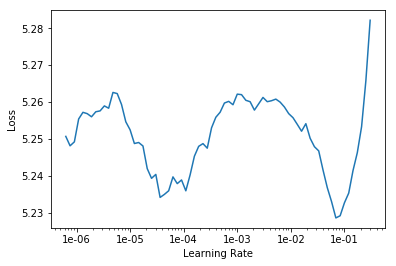

In [26]:
learn.recorder.plot(skip_end=18)

In [27]:
learn.fit_one_cycle(1, 3e-2, moms=(0.8,0.7))

Total time: 1:08:24
epoch  train_loss  valid_loss  accuracy
1      4.667898    4.540023    0.244075  (1:08:24)



In [28]:
learn.save('fit_head')

In [ ]:
learn.load('fit_head');

To complete the fine-tuning, we can then unfeeze and launch a new training.

In [29]:
learn.unfreeze()
learn.fit_one_cycle(10, 1e-3, moms=(0.8,0.7))

Total time: 12:53:24
epoch  train_loss  valid_loss  accuracy
1      4.366923    4.318609    0.265980  (1:16:27)
2      4.281978    4.212987    0.277898  (1:16:55)
3      4.219072    4.151357    0.284877  (1:17:46)
4      4.149745    4.100978    0.290114  (1:17:37)
5      4.078106    4.064893    0.294025  (1:17:07)
6      4.010452    4.037675    0.297239  (1:17:47)
7      3.965625    4.017648    0.299207  (1:17:20)
8      3.927432    4.005197    0.300762  (1:17:28)
9      3.878176    3.999400    0.301535  (1:17:22)
10     3.848057    3.999415    0.301492  (1:17:32)



In [30]:
learn.save('fine_tuned')

How good is our model? Well let's try to see what it predicts after a few given words.

In [ ]:
learn.load('fine_tuned');

In [31]:
learn.predict('I liked this movie because ', 100, temperature=1.1, min_p=0.001)

Total time: 00:08



'I liked this movie because  the way of course , there were the result - it was completely unknown . i was n\'t even if you think , they still under the movie version of course to be able to do n\'t look up and then he had it takes an attempt at the movie . xxfld 1 ) , however , the whole production values . as a few words that was very well - based on a real life , not only 2 . this whole place , " we all over the xxup not at the whole enterprise . from the xxup'

We have to save the model but also it's encoder, the part that's responsible for creating and updating the hidden state. For the next part, we don't care about the part that tries to guess the next word.

In [32]:
learn.save_encoder('fine_tuned_enc')

## Classifier

Now, we'll create a new data object that only grabs the labelled data and keeps those labels. Again, this line takes a bit of time.

In [33]:
data_clas = (TextList.from_folder(path, vocab=data_lm.vocab)
             #grab all the text files in path
            .split_by_folder(valid='test')
             #split by train and valid folder (that only keeps 'train' and 'test' so no need to filter)
            .label_from_folder(classes=['neg', 'pos'])
             #label them all with their folders
            .databunch(bs=50))
data_clas.save('tmp_clas')

In [34]:
data_clas = TextClasDataBunch.load(path, 'tmp_clas', bs=50)
data_clas.show_batch()

text,label
"xxfld 1 * * * xxup spoilers * * * * * * xxup spoilers * * * the first godzilla movie in the third movie series , whereas xxup godzilla vs. xxup xxunk , the previous entry , aptly ended the second series . what else can i say",[['neg' 'pos']]
"xxfld 1 ok , sorry , i could n't resist . though this is a pretty grim movie at times , i ca n't hear the phrase "" spanish inquisition "" without going through the monty python routine . once the movie starts , however , i am always so",[['neg' 'pos']]
"xxfld 1 to the producers of "" boudica "" \n\n all my life i have had a special interest in ancient celtic culture and lifestyle and a particular fascination for 1st century britain . therefore i have done a great lot of research over the years and read and watch",[['neg' 'pos']]
"xxfld 1 following up to the first jedi knight was not going to be easy . it had it all , and it was all very accomplished . this does an amazing job , even if it does n't reach it all the xxunk could ? ) . the plot",[['neg' 'pos']]
"xxfld 1 \n\n rating : 2 out of 10 ; 1 / 2 star \n\n part ii \n\n more problems with the film : \n\n ( 6 ) xxup major xxup xxunk of xxup history , 1982 xxup ncaa finals , xxup xxunk vs. georgetown - in the film ,",[['neg' 'pos']]


We can then create a model to classify those reviews and load the encoder we saved before.

In [46]:
learn = text_classifier_learner(data_clas, drop_mult=0.5)
learn.load_encoder('fine_tuned_enc')
learn.freeze()

In [48]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


RuntimeError: Could not infer dtype of NoneType

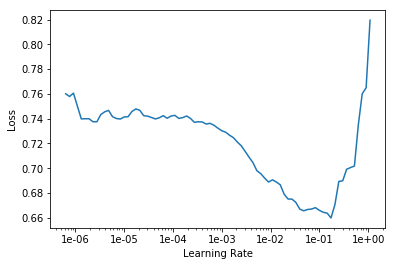

In [ ]:
learn.recorder.plot()

In [ ]:
learn.fit_one_cycle(1, 2e-2, moms=(0.8,0.7))

Total time: 02:46
epoch  train_loss  valid_loss  accuracy
1      0.294225    0.210385    0.918960  (02:46)



In [ ]:
learn.save('first')

In [ ]:
learn.load('first');

In [ ]:
learn.freeze_to(-2)
learn.fit_one_cycle(1, slice(1e-2/(2.6**4),1e-2), moms=(0.8,0.7))

Total time: 03:03
epoch  train_loss  valid_loss  accuracy
1      0.268781    0.180993    0.930760  (03:03)



In [ ]:
learn.save('second')

In [ ]:
learn.load('second');

In [ ]:
learn.freeze_to(-3)
learn.fit_one_cycle(1, slice(5e-3/(2.6**4),5e-3), moms=(0.8,0.7))

Total time: 04:06
epoch  train_loss  valid_loss  accuracy
1      0.211133    0.161494    0.941280  (04:06)



In [ ]:
learn.save('third')

In [ ]:
learn.load('third');

In [ ]:
learn.unfreeze()
learn.fit_one_cycle(2, slice(1e-3/(2.6**4),1e-3), moms=(0.8,0.7))

Total time: 10:01
epoch  train_loss  valid_loss  accuracy
1      0.188145    0.155038    0.942480  (05:00)
2      0.159475    0.153531    0.944040  (05:01)



In [ ]:
learn.predict("I really loved that movie, it was awesome!")

('pos', tensor(0), tensor([[9.9999e-01, 1.1991e-05]]))